In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
Kemondo_Sales_final = pd.read_excel('/content/sample_data/Kemondo_Sales_final.xlsx')

/tmp/ipython-input-1962601172.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = Kemondo_Sales_final.set_index('Date').resample('M')['Sales'].sum().reset_index()


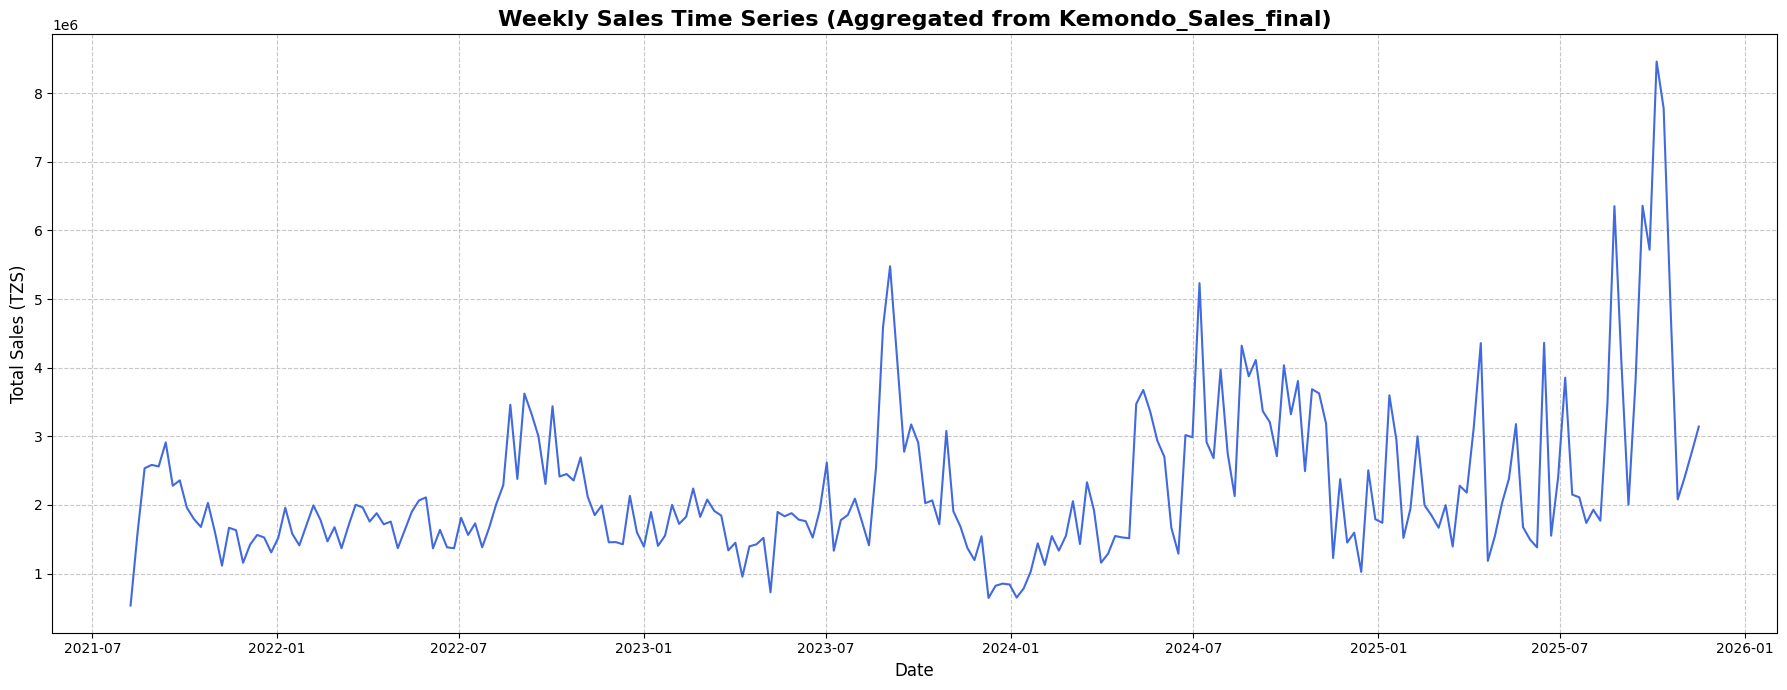

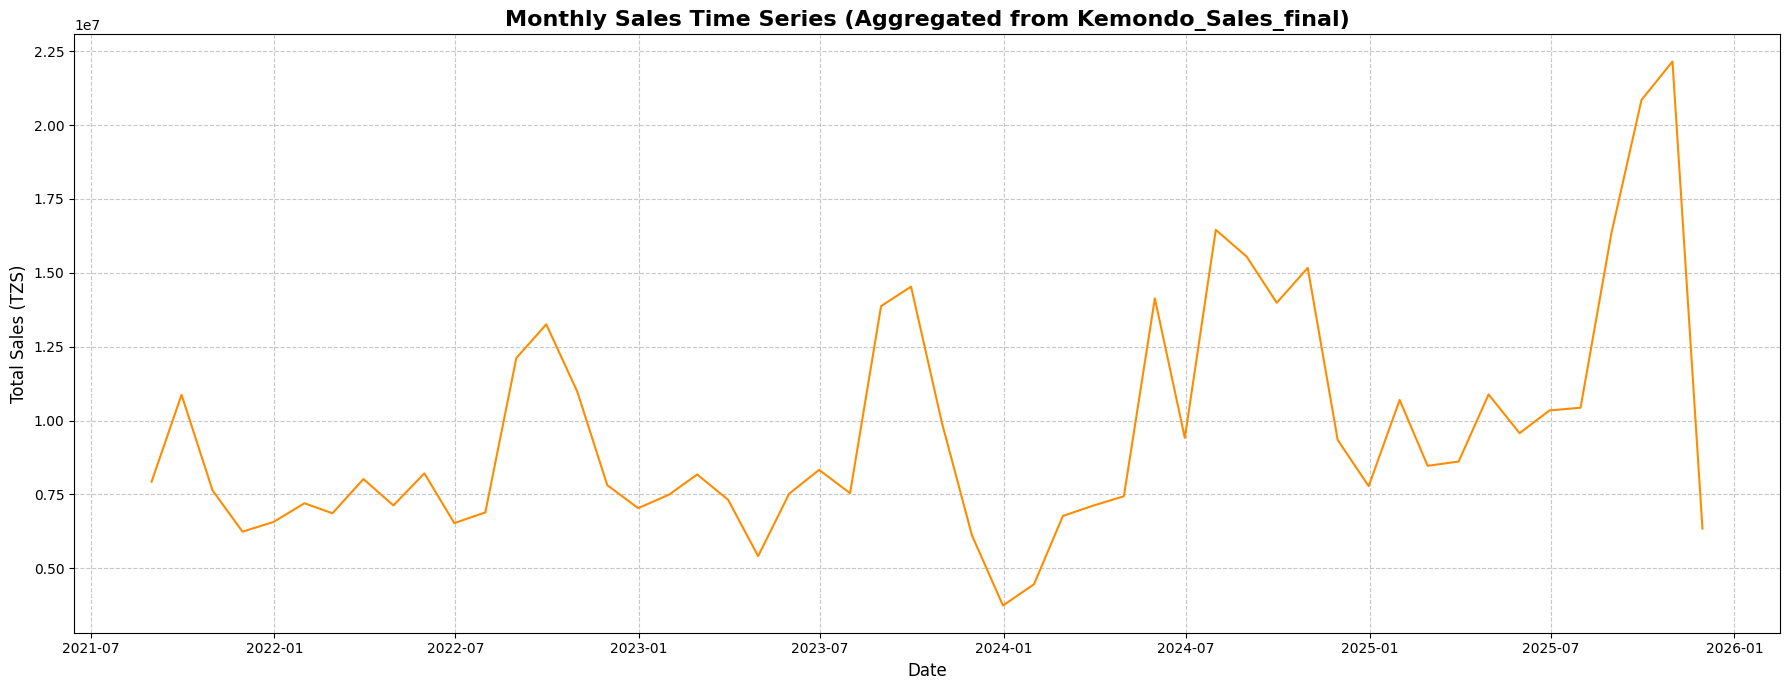


Weekly Sales (first 5 rows):


,Date,Sales
0,2021-08-08,535120.0
1,2021-08-15,1598517.5
2,2021-08-22,2535590.0
3,2021-08-29,2583585.0
4,2021-09-05,2561950.0



Monthly Sales (first 5 rows):


,Date,Sales
0,2021-08-31,7929402.50
1,2021-09-30,10872400.00
2,2021-10-31,7637137.50
3,2021-11-30,6239950.00
4,2021-12-31,6568134.97


In [4]:

# --- Weekly Time Series Aggregation ---
weekly_sales = Kemondo_Sales_final.set_index('Date').resample('W')['Sales'].sum().reset_index()

# --- Monthly Time Series Aggregation ---
monthly_sales = Kemondo_Sales_final.set_index('Date').resample('M')['Sales'].sum().reset_index()

# --- Plotting Weekly Time Series ---
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_sales, color='royalblue', linewidth=1.5)
plt.title('Weekly Sales Time Series (Aggregated from Kemondo_Sales_final)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plotting Monthly Time Series ---
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_sales, color='darkorange', linewidth=1.5)
plt.title('Monthly Sales Time Series (Aggregated from Kemondo_Sales_final)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nWeekly Sales (first 5 rows):")
display(weekly_sales.head())
print("\nMonthly Sales (first 5 rows):")
display(monthly_sales.head())

In [5]:
# --- Split Weekly Sales Data ---

# Calculate the split point (80% for training, 20% for testing)
split_point_weekly = int(len(weekly_sales) * 0.8)

# Split the weekly data
weekly_train = weekly_sales.iloc[:split_point_weekly]
weekly_test = weekly_sales.iloc[split_point_weekly:]

print("\n--- Weekly Sales Data Split ---")
print(f"Weekly Training Data Shape: {weekly_train.shape}")
print(f"Weekly Training Data Date Range: {weekly_train['Date'].min().strftime('%Y-%m-%d')} to {weekly_train['Date'].max().strftime('%Y-%m-%d')}")
print(f"Weekly Test Data Shape: {weekly_test.shape}")
print(f"Weekly Test Data Date Range: {weekly_test['Date'].min().strftime('%Y-%m-%d')} to {weekly_test['Date'].max().strftime('%Y-%m-%d')}")

# --- Split Monthly Sales Data ---

# Calculate the split point (80% for training, 20% for testing)
split_point_monthly = int(len(monthly_sales) * 0.8)

# Split the monthly data
monthly_train = monthly_sales.iloc[:split_point_monthly]
monthly_test = monthly_sales.iloc[split_point_monthly:]

print("\n--- Monthly Sales Data Split ---")
print(f"Monthly Training Data Shape: {monthly_train.shape}")
print(f"Monthly Training Data Date Range: {monthly_train['Date'].min().strftime('%Y-%m-%d')} to {monthly_train['Date'].max().strftime('%Y-%m-%d')}")
print(f"Monthly Test Data Shape: {monthly_test.shape}")
print(f"Monthly Test Data Date Range: {monthly_test['Date'].min().strftime('%Y-%m-%d')} to {monthly_test['Date'].max().strftime('%Y-%m-%d')}")



--- Weekly Sales Data Split ---
Weekly Training Data Shape: (179, 2)
Weekly Training Data Date Range: 2021-08-08 to 2025-01-05
Weekly Test Data Shape: (45, 2)
Weekly Test Data Date Range: 2025-01-12 to 2025-11-16

--- Monthly Sales Data Split ---
Monthly Training Data Shape: (41, 2)
Monthly Training Data Date Range: 2021-08-31 to 2024-12-31
Monthly Test Data Shape: (11, 2)
Monthly Test Data Date Range: 2025-01-31 to 2025-11-30


# **NAIVE FORECASTS**


--- Weekly Naive Forecast Results ---
Weekly Naive Forecast MAE: 1,333,442.90
Weekly Naive Forecast RMSE: 2,093,494.33
Weekly Test Data with Naive Forecast (first 5 rows):


,Date,Sales,Naive_Forecast
179,2025-01-12,3.598200e+06,1740300.0
180,2025-01-19,2.945100e+06,1740300.0
181,2025-01-26,1.520700e+06,1740300.0
182,2025-02-02,1.948601e+06,1740300.0
183,2025-02-09,3.000496e+06,1740300.0


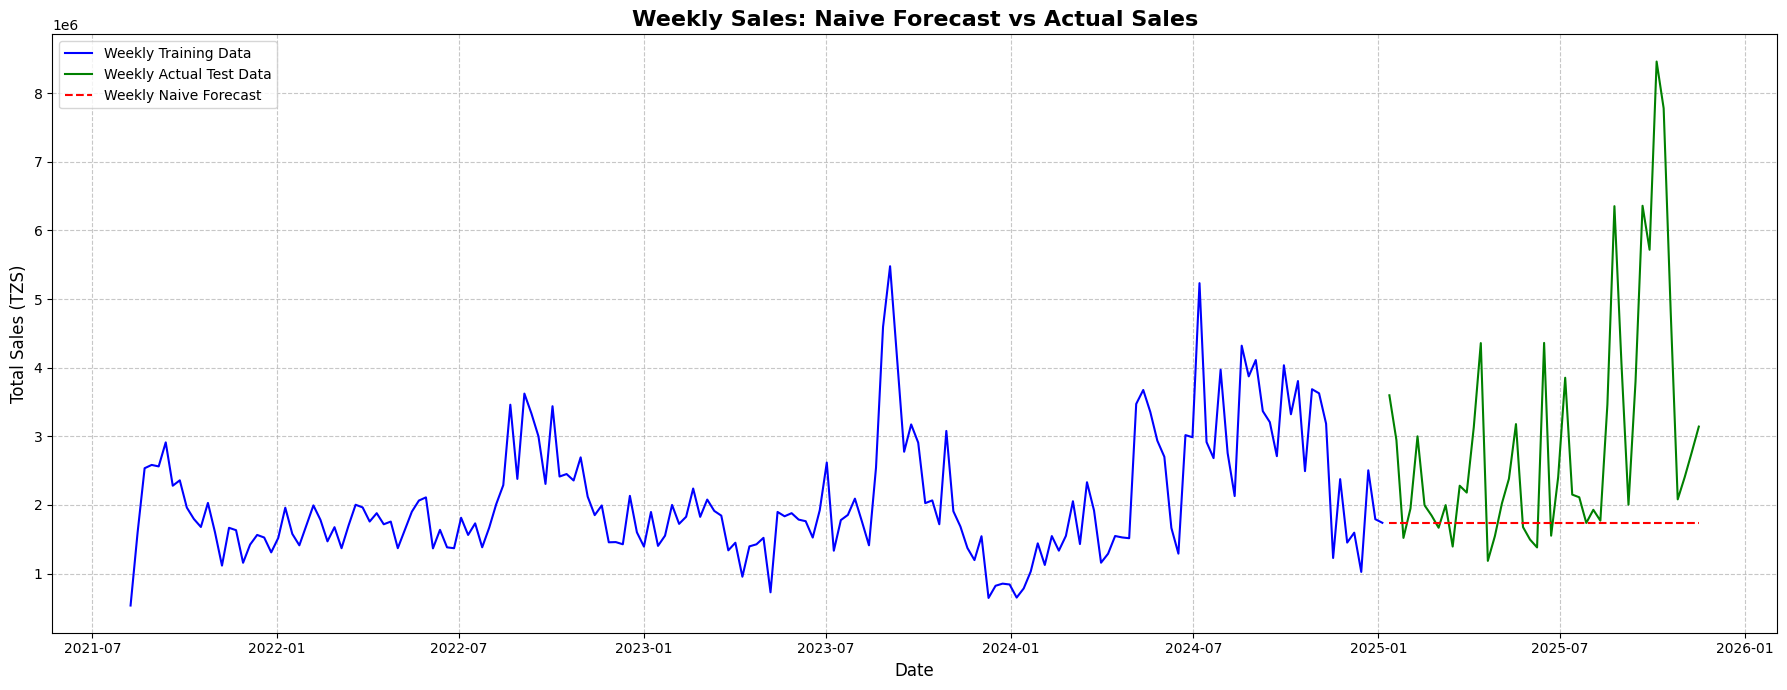


--- Monthly Naive Forecast Results ---
Monthly Naive Forecast MAE: 4,728,468.09
Monthly Naive Forecast RMSE: 6,668,554.47
Monthly Test Data with Naive Forecast (first 5 rows):


,Date,Sales,Naive_Forecast
41,2025-01-31,1.069730e+07,7779400.0
42,2025-02-28,8.468596e+06,7779400.0
43,2025-03-31,8.613659e+06,7779400.0
44,2025-04-30,1.088368e+07,7779400.0
45,2025-05-31,9.573300e+06,7779400.0


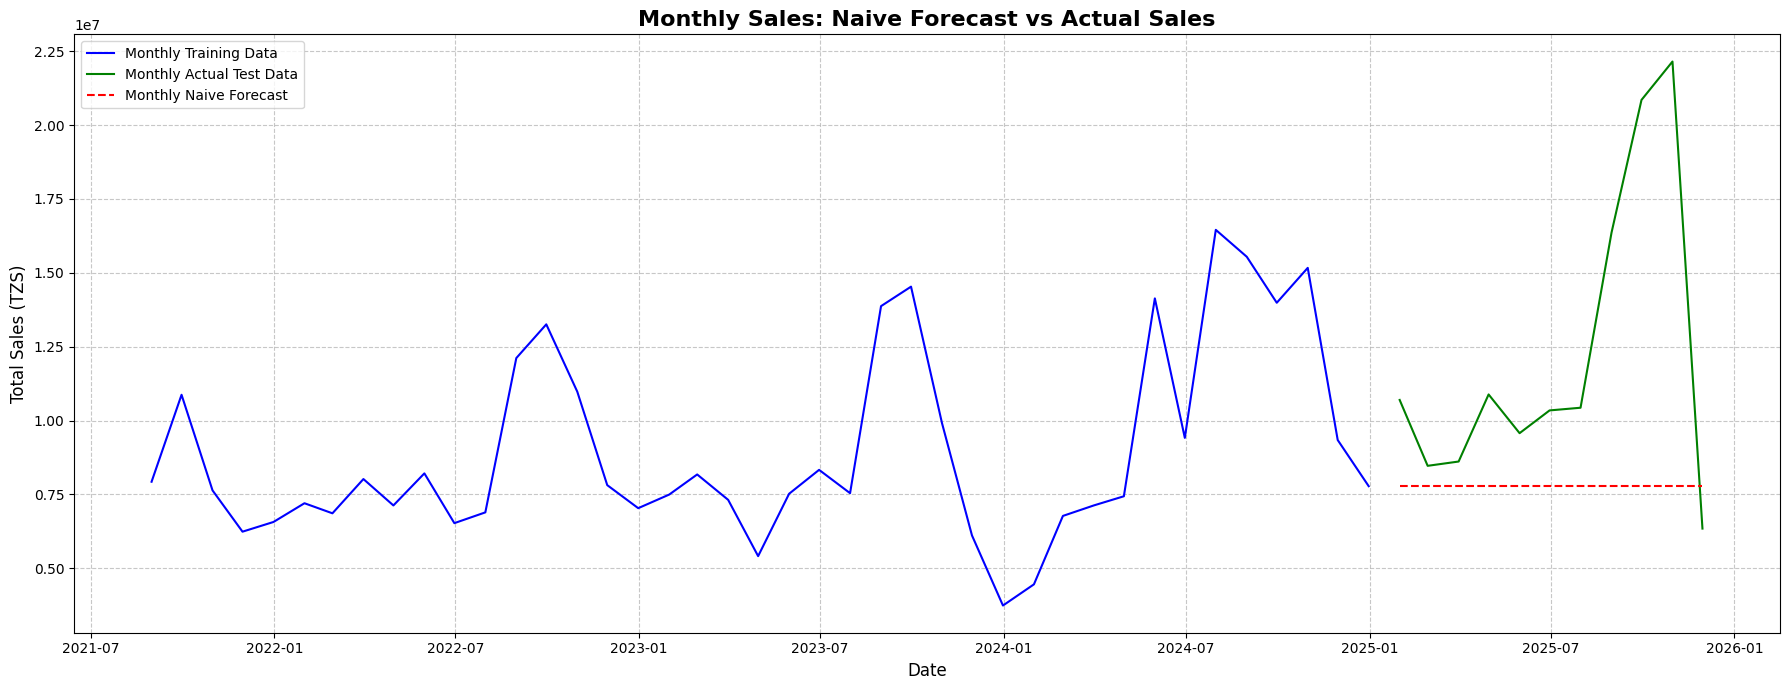

In [ ]:
# Naive Forecast for Weekly Sales

# Initializing naive forecast for weekly test data
weekly_test_forecast = weekly_test.copy()

# The forecast for all test periods is the last value from the training set
weekly_test_forecast['Naive_Forecast'] = weekly_train['Sales'].iloc[-1]

# Calculating evaluation metrics for weekly data
weekly_naive_mae = mean_absolute_error(weekly_test_forecast['Sales'], weekly_test_forecast['Naive_Forecast'])
weekly_naive_rmse = np.sqrt(mean_squared_error(weekly_test_forecast['Sales'], weekly_test_forecast['Naive_Forecast']))

print("\n--- Weekly Naive Forecast Results ---")
print(f"Weekly Naive Forecast MAE: {weekly_naive_mae:,.2f}")
print(f"Weekly Naive Forecast RMSE: {weekly_naive_rmse:,.2f}")
print("Weekly Test Data with Naive Forecast (first 5 rows):")
display(weekly_test_forecast.head())

# Plotting Weekly Naive Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_train, label='Weekly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=weekly_test_forecast, label='Weekly Actual Test Data', color='green')
sns.lineplot(x='Date', y='Naive_Forecast', data=weekly_test_forecast, label='Weekly Naive Forecast', color='red', linestyle='--')
plt.title('Weekly Sales: Naive Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Naive Forecast for Monthly Sales


# Initializing naive forecast for monthly test data
monthly_test_forecast = monthly_test.copy()

# The forecast for all test periods is the last value from the training set
monthly_test_forecast['Naive_Forecast'] = monthly_train['Sales'].iloc[-1]

# Calculating evaluation metrics for monthly data
monthly_naive_mae = mean_absolute_error(monthly_test_forecast['Sales'], monthly_test_forecast['Naive_Forecast'])
monthly_naive_rmse = np.sqrt(mean_squared_error(monthly_test_forecast['Sales'], monthly_test_forecast['Naive_Forecast']))

print("\n--- Monthly Naive Forecast Results ---")
print(f"Monthly Naive Forecast MAE: {monthly_naive_mae:,.2f}")
print(f"Monthly Naive Forecast RMSE: {monthly_naive_rmse:,.2f}")
print("Monthly Test Data with Naive Forecast (first 5 rows):")
display(monthly_test_forecast.head())

# Plotting Monthly Naive Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_train, label='Monthly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=monthly_test_forecast, label='Monthly Actual Test Data', color='green')
sns.lineplot(x='Date', y='Naive_Forecast', data=monthly_test_forecast, label='Monthly Naive Forecast', color='red', linestyle='--')
plt.title('Monthly Sales: Naive Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **HOLT-WINTERS FORECAST**


--- Weekly Holt-Winters Forecast Results ---
Weekly HW Forecast MAE: 1,132,740.78
Weekly HW Forecast RMSE: 1,595,932.54

Model Parameters:
  Alpha (level): 0.3203
  Beta (trend): 0.0000
  Gamma (seasonal): 0.0000

Weekly Test Data with Holt-Winters Forecast (first 5 rows):


,Date,Sales,HW_Forecast
179,2025-01-12,3.598200e+06,1.601445e+06
180,2025-01-19,2.945100e+06,1.789519e+06
181,2025-01-26,1.520700e+06,2.203488e+06
182,2025-02-02,1.948601e+06,2.542797e+06
183,2025-02-09,3.000496e+06,2.487586e+06


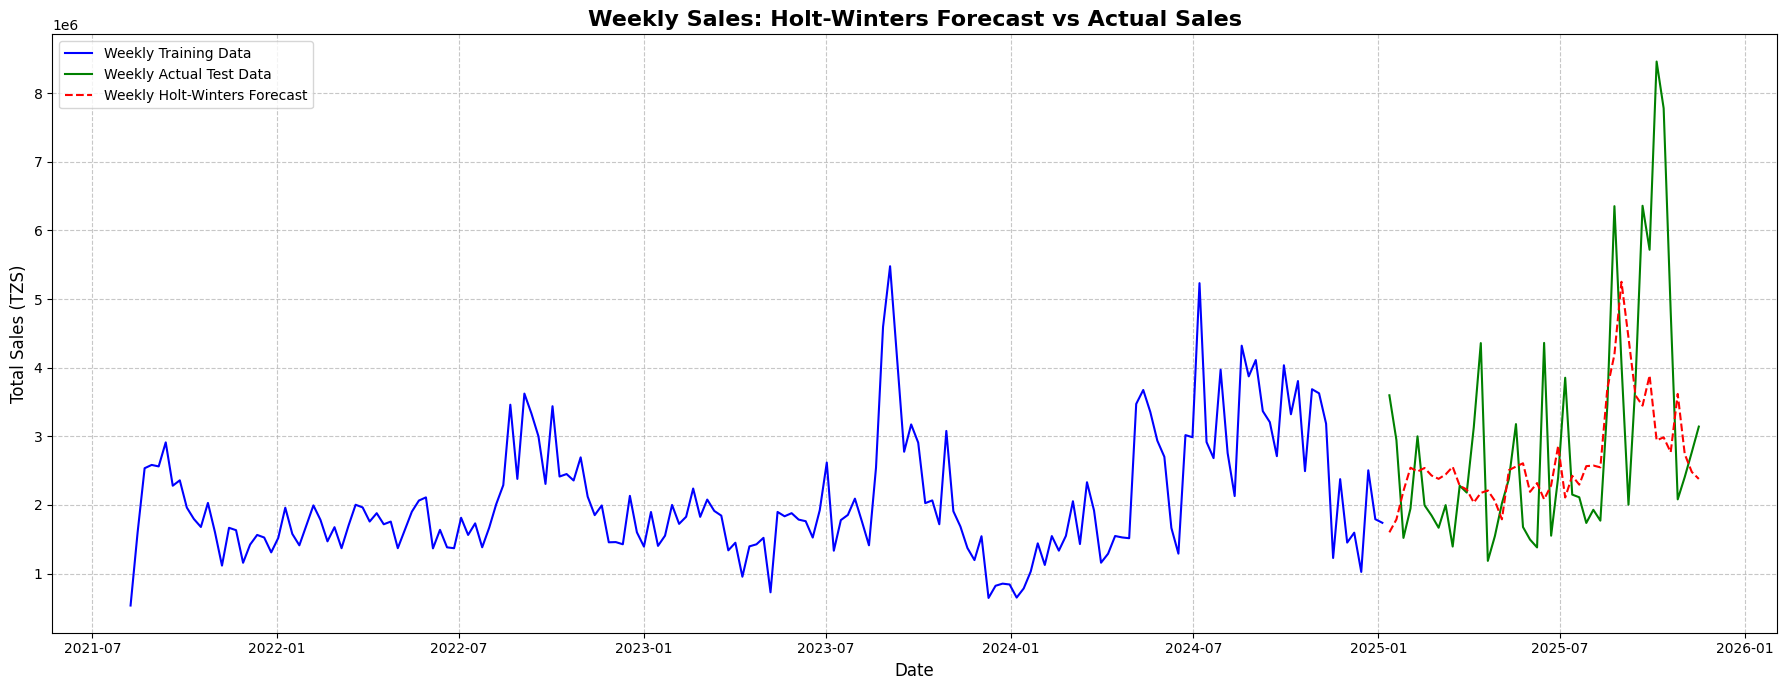


--- Monthly Holt-Winters Forecast Results ---
Monthly HW Forecast MAE: 2,646,188.23
Monthly HW Forecast RMSE: 3,182,899.26

Model Parameters:
  Alpha (level): 0.4394
  Beta (trend): 0.0000
  Gamma (seasonal): 0.0000

Monthly Test Data with Holt-Winters Forecast (first 5 rows):


,Date,Sales,HW_Forecast
41,2025-01-31,1.069730e+07,8.831366e+06
42,2025-02-28,8.468596e+06,1.118481e+07
43,2025-03-31,8.613659e+06,1.135718e+07
44,2025-04-30,1.088368e+07,1.005631e+07
45,2025-05-31,9.573300e+06,1.191466e+07


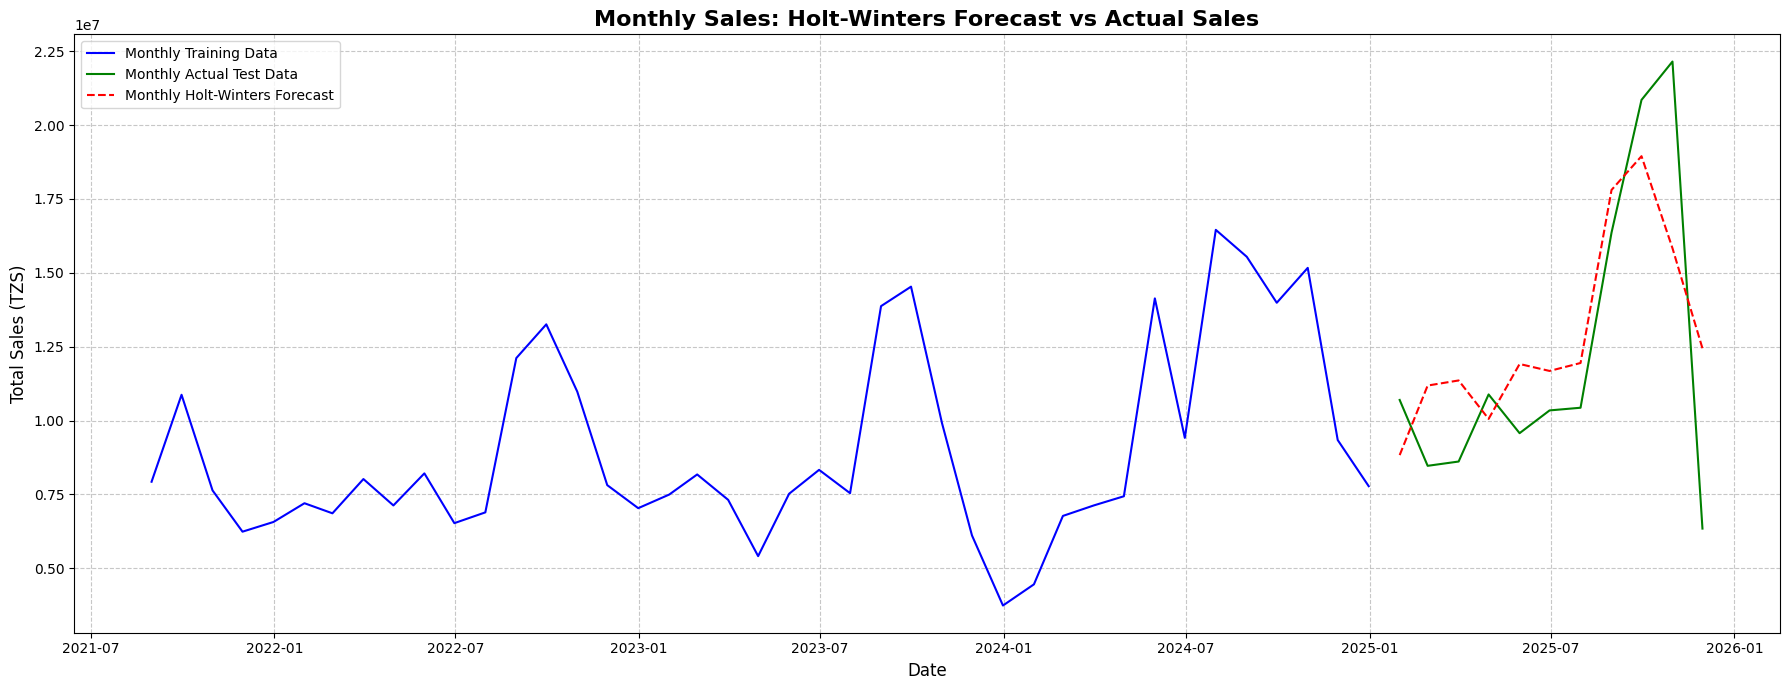

In [ ]:

# Holt-Winters Forecast for Weekly Sales


# Fitting Holt-Winters model on weekly training data
weekly_hw_model = ExponentialSmoothing(
    weekly_train['Sales'],
    seasonal_periods=52,  # weeks in a year
    trend='add',
    seasonal='add',
    initialization_method='estimated'
).fit()

# Generating forecast for the test period
weekly_test_forecast_hw = weekly_test.copy()
weekly_forecast_values = weekly_hw_model.forecast(steps=len(weekly_test))
weekly_test_forecast_hw['HW_Forecast'] = weekly_forecast_values.values

# Calculating evaluation metrics for weekly data
weekly_hw_mae = mean_absolute_error(weekly_test_forecast_hw['Sales'], weekly_test_forecast_hw['HW_Forecast'])
weekly_hw_rmse = np.sqrt(mean_squared_error(weekly_test_forecast_hw['Sales'], weekly_test_forecast_hw['HW_Forecast']))

print("\n--- Weekly Holt-Winters Forecast Results ---")
print(f"Weekly HW Forecast MAE: {weekly_hw_mae:,.2f}")
print(f"Weekly HW Forecast RMSE: {weekly_hw_rmse:,.2f}")
print("\nModel Parameters:")
print(f"  Alpha (level): {weekly_hw_model.params['smoothing_level']:.4f}")
print(f"  Beta (trend): {weekly_hw_model.params['smoothing_trend']:.4f}")
print(f"  Gamma (seasonal): {weekly_hw_model.params['smoothing_seasonal']:.4f}")
print("\nWeekly Test Data with Holt-Winters Forecast (first 5 rows):")
display(weekly_test_forecast_hw.head())

# Plotting Weekly Holt-Winters Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_train, label='Weekly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=weekly_test_forecast_hw, label='Weekly Actual Test Data', color='green')
sns.lineplot(x='Date', y='HW_Forecast', data=weekly_test_forecast_hw, label='Weekly Holt-Winters Forecast', color='red', linestyle='--')
plt.title('Weekly Sales: Holt-Winters Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Holt-Winters Forecast for Monthly Sales


# Fitting Holt-Winters model on monthly training data
monthly_hw_model = ExponentialSmoothing(
    monthly_train['Sales'],
    seasonal_periods=12,  # months in a year
    trend='add',
    seasonal='add',
    initialization_method='estimated'
).fit()

# Generating forecast for the test period
monthly_test_forecast_hw = monthly_test.copy()
monthly_forecast_values = monthly_hw_model.forecast(steps=len(monthly_test))
monthly_test_forecast_hw['HW_Forecast'] = monthly_forecast_values.values

# Calculating evaluation metrics for monthly data
monthly_hw_mae = mean_absolute_error(monthly_test_forecast_hw['Sales'], monthly_test_forecast_hw['HW_Forecast'])
monthly_hw_rmse = np.sqrt(mean_squared_error(monthly_test_forecast_hw['Sales'], monthly_test_forecast_hw['HW_Forecast']))

print("\n--- Monthly Holt-Winters Forecast Results ---")
print(f"Monthly HW Forecast MAE: {monthly_hw_mae:,.2f}")
print(f"Monthly HW Forecast RMSE: {monthly_hw_rmse:,.2f}")
print("\nModel Parameters:")
print(f"  Alpha (level): {monthly_hw_model.params['smoothing_level']:.4f}")
print(f"  Beta (trend): {monthly_hw_model.params['smoothing_trend']:.4f}")
print(f"  Gamma (seasonal): {monthly_hw_model.params['smoothing_seasonal']:.4f}")
print("\nMonthly Test Data with Holt-Winters Forecast (first 5 rows):")
display(monthly_test_forecast_hw.head())

# Plotting Monthly Holt-Winters Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_train, label='Monthly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=monthly_test_forecast_hw, label='Monthly Actual Test Data', color='green')
sns.lineplot(x='Date', y='HW_Forecast', data=monthly_test_forecast_hw, label='Monthly Holt-Winters Forecast', color='red', linestyle='--')
plt.title('Monthly Sales: Holt-Winters Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **SARIMA FORECASTS**

In [ ]:
# Auto-Select Best SARIMA Parameters (Grid Search)


def find_best_sarima(train_data, seasonal_period, max_p=3, max_q=3, max_P=2, max_Q=2):
    """
    Performs grid search to find best SARIMA parameters based on AIC
    """
    best_aic = np.inf
    best_params = None
    best_seasonal_params = None

    print(f"\nSearching for best SARIMA parameters (seasonal period={seasonal_period})...")

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            for P in range(max_P + 1):
                for Q in range(max_Q + 1):
                    try:
                        model = SARIMAX(
                            train_data,
                            order=(p, 1, q),
                            seasonal_order=(P, 1, Q, seasonal_period),
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        ).fit(disp=False)

                        if model.aic < best_aic:
                            best_aic = model.aic
                            best_params = (p, 1, q)
                            best_seasonal_params = (P, 1, Q, seasonal_period)
                    except:
                        continue

    print(f"Best parameters: SARIMA{best_params}{best_seasonal_params}")
    print(f"Best AIC: {best_aic:.2f}")

    return best_params, best_seasonal_params

In [ ]:
best_order_weekly, best_seasonal_weekly = find_best_sarima(
    train_data=weekly_train['Sales'],
    seasonal_period=52,
    max_p=2, max_q=2, max_P=1, max_Q=1
)

best_order_monthly, best_seasonal_monthly = find_best_sarima(
    train_data=monthly_train['Sales'],
    seasonal_period=12,
    max_p=2, max_q=2, max_P=1, max_Q=1
)



Searching for best SARIMA parameters (seasonal period=52)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimat

Best parameters: SARIMA(0, 1, 2)(1, 1, 1, 52)
Best AIC: 2133.03

Searching for best SARIMA parameters (seasonal period=12)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimat

Best parameters: SARIMA(2, 1, 2)(0, 1, 1, 12)
Best AIC: 430.32


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



--- Weekly SARIMA Forecast Results ---
Model: SARIMA(0,1,2)(1,1,1,52)
Weekly SARIMA Forecast MAE: 1,256,971.56
Weekly SARIMA Forecast RMSE: 1,614,320.28

AIC: 2133.03
BIC: 2144.34

Weekly Test Data with SARIMA Forecast (first 5 rows):


,Date,Sales,SARIMA_Forecast
179,2025-01-12,3.598200e+06,1.537926e+06
180,2025-01-19,2.945100e+06,1.901131e+06
181,2025-01-26,1.520700e+06,2.304950e+06
182,2025-02-02,1.948601e+06,1.702487e+06
183,2025-02-09,3.000496e+06,2.145758e+06


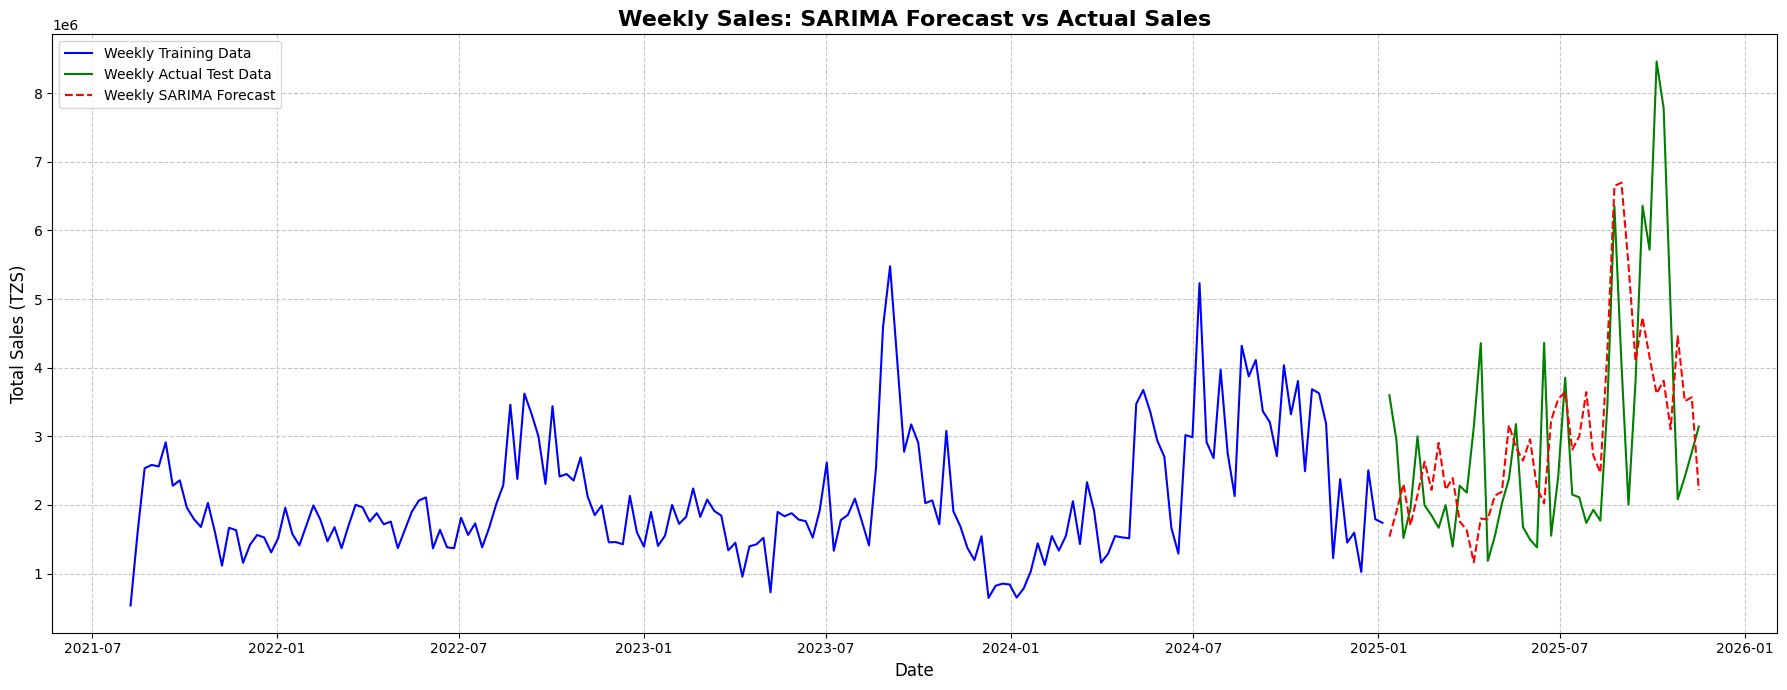

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



--- Monthly SARIMA Forecast Results ---
Model: SARIMA(1,1,1)(1,1,1,12)
Monthly SARIMA Forecast MAE: 2,990,713.73
Monthly SARIMA Forecast RMSE: 3,614,530.71

AIC: 462.65
BIC: 465.85

Monthly Test Data with SARIMA Forecast (first 5 rows):


,Date,Sales,SARIMA_Forecast
41,2025-01-31,1.069730e+07,7.453003e+06
42,2025-02-28,8.468596e+06,9.634663e+06
43,2025-03-31,8.613659e+06,6.625042e+06
44,2025-04-30,1.088368e+07,5.159219e+06
45,2025-05-31,9.573300e+06,8.309847e+06


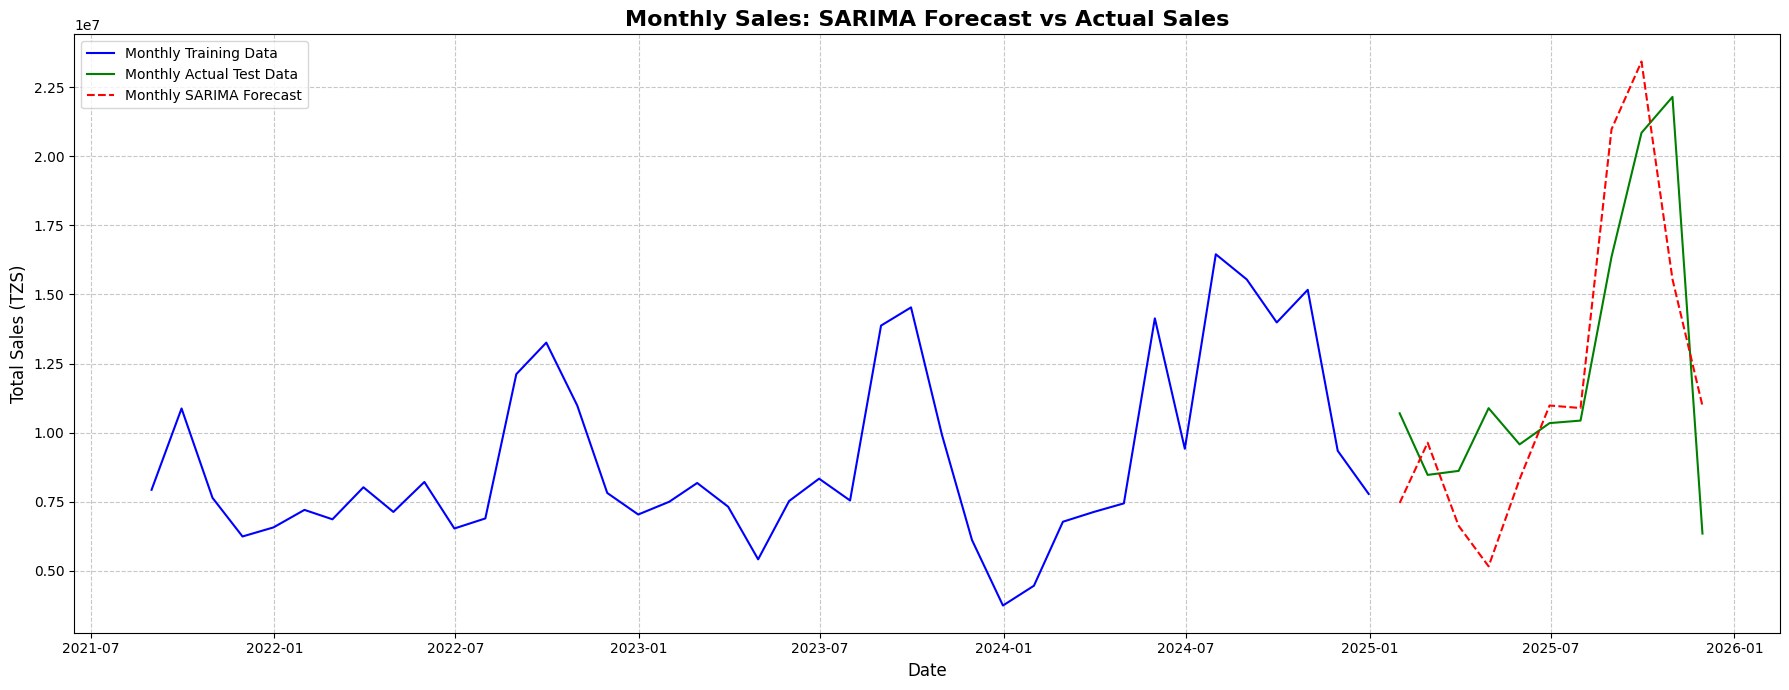

In [6]:

# SARIMA Forecast for Weekly Sales

# Fitting SARIMA model on weekly training data

weekly_sarima_model = SARIMAX(
    weekly_train['Sales'],
    order=(0, 1, 2),           # (p, d, q)
    seasonal_order=(1, 1, 1, 52),  # (P, D, Q, s)  s=52 weeks
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Generating forecast for the test period
weekly_test_forecast_sarima = weekly_test.copy()
weekly_sarima_forecast = weekly_sarima_model.forecast(steps=len(weekly_test))
weekly_test_forecast_sarima['SARIMA_Forecast'] = weekly_sarima_forecast.values

# Calculating evaluation metrics for weekly data
weekly_sarima_mae = mean_absolute_error(weekly_test_forecast_sarima['Sales'], weekly_test_forecast_sarima['SARIMA_Forecast'])
weekly_sarima_rmse = np.sqrt(mean_squared_error(weekly_test_forecast_sarima['Sales'], weekly_test_forecast_sarima['SARIMA_Forecast']))

print("\n--- Weekly SARIMA Forecast Results ---")
print(f"Model: SARIMA(0,1,2)(1,1,1,52)")
print(f"Weekly SARIMA Forecast MAE: {weekly_sarima_mae:,.2f}")
print(f"Weekly SARIMA Forecast RMSE: {weekly_sarima_rmse:,.2f}")
print(f"\nAIC: {weekly_sarima_model.aic:.2f}")
print(f"BIC: {weekly_sarima_model.bic:.2f}")
print("\nWeekly Test Data with SARIMA Forecast (first 5 rows):")
display(weekly_test_forecast_sarima.head())

# Plotting Weekly SARIMA Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_train, label='Weekly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=weekly_test_forecast_sarima, label='Weekly Actual Test Data', color='green')
sns.lineplot(x='Date', y='SARIMA_Forecast', data=weekly_test_forecast_sarima, label='Weekly SARIMA Forecast', color='red', linestyle='--')
plt.title('Weekly Sales: SARIMA Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# SARIMA Forecast for Monthly Sales


# Fitting SARIMA model on monthly training data
monthly_sarima_model = SARIMAX(
    monthly_train['Sales'],
    order=(1, 1, 1),           # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, s)  s=12 months
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Generating forecast for the test period
monthly_test_forecast_sarima = monthly_test.copy()
monthly_sarima_forecast = monthly_sarima_model.forecast(steps=len(monthly_test))
monthly_test_forecast_sarima['SARIMA_Forecast'] = monthly_sarima_forecast.values

# Calculating evaluation metrics for monthly data
monthly_sarima_mae = mean_absolute_error(monthly_test_forecast_sarima['Sales'], monthly_test_forecast_sarima['SARIMA_Forecast'])
monthly_sarima_rmse = np.sqrt(mean_squared_error(monthly_test_forecast_sarima['Sales'], monthly_test_forecast_sarima['SARIMA_Forecast']))

print("\n--- Monthly SARIMA Forecast Results ---")
print(f"Model: SARIMA(1,1,1)(1,1,1,12)")
print(f"Monthly SARIMA Forecast MAE: {monthly_sarima_mae:,.2f}")
print(f"Monthly SARIMA Forecast RMSE: {monthly_sarima_rmse:,.2f}")
print(f"\nAIC: {monthly_sarima_model.aic:.2f}")
print(f"BIC: {monthly_sarima_model.bic:.2f}")
print("\nMonthly Test Data with SARIMA Forecast (first 5 rows):")
display(monthly_test_forecast_sarima.head())

# Plotting Monthly SARIMA Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_train, label='Monthly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=monthly_test_forecast_sarima, label='Monthly Actual Test Data', color='green')
sns.lineplot(x='Date', y='SARIMA_Forecast', data=monthly_test_forecast_sarima, label='Monthly SARIMA Forecast', color='red', linestyle='--')
plt.title('Monthly Sales: SARIMA Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




<Figure size 1000x400 with 0 Axes>

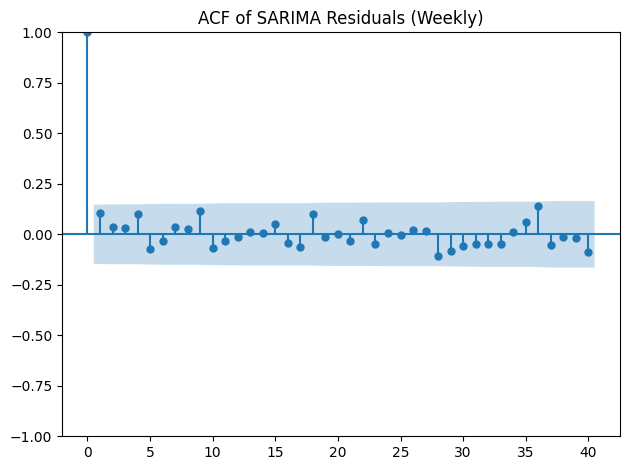

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf

# residuals
resid = weekly_sarima_model.resid.dropna()

plt.figure(figsize=(10, 4))
plot_acf(resid, lags=40)
plt.title("ACF of SARIMA Residuals (Weekly)")
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = weekly_sarima_model.resid.dropna()


lags_to_test = [5, 10, 15, 20]
lags_to_test = [l for l in lags_to_test if l < len(resid)]

lb = acorr_ljungbox(resid, lags=lags_to_test, return_df=True)
print(lb)


      lb_stat  lb_pvalue
5    5.215683   0.390129
10   9.240492   0.509442
15  10.087173   0.814221
20  13.473759   0.856145


<Figure size 1000x400 with 0 Axes>

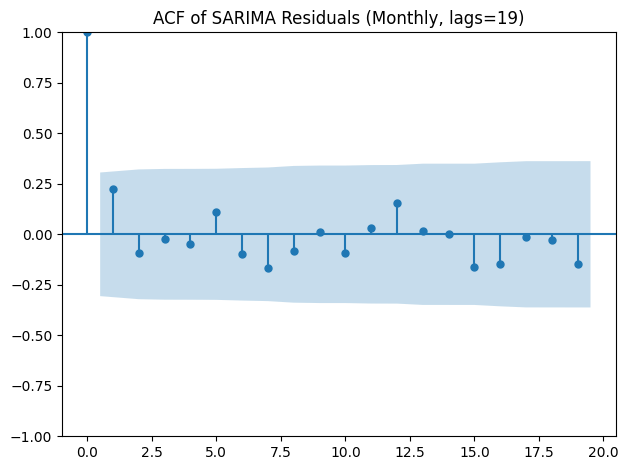

     lb_stat  lb_pvalue
5   3.357823   0.645001
10  6.137338   0.803596
15  9.434778   0.853710


In [ ]:
resid_m = monthly_sarima_model.resid.dropna()

lags_m = max(5, min(24, len(resid_m)//2 - 1))
plt.figure(figsize=(10, 4))
plot_acf(resid_m, lags=lags_m)
plt.title(f"ACF of SARIMA Residuals (Monthly, lags={lags_m})")
plt.tight_layout()
plt.show()

lb_m = acorr_ljungbox(resid_m, lags=[5, 10, 15], return_df=True)
print(lb_m)


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = monthly_sarima_model.resid.dropna()

# choose a few lags to report (works better than one huge lag)
lags_to_test = [5, 10, 15, 20]
lags_to_test = [l for l in lags_to_test if l < len(resid)]

lb = acorr_ljungbox(resid, lags=lags_to_test, return_df=True)
print(lb)

      lb_stat  lb_pvalue
5    3.357823   0.645001
10   6.137338   0.803596
15   9.434778   0.853710
20  13.311441   0.863625


# **PROPHET FORECASTS**

In [ ]:
def tune_prophet_parameters(train_data, test_data, param_grid):
    best_mae = np.inf
    best_params = None
    results = []

    for seasonality_mode in param_grid['seasonality_mode']:
        for changepoint_prior in param_grid['changepoint_prior_scale']:
            for seasonality_prior in param_grid['seasonality_prior_scale']:
                try:
                    model = Prophet(
                        seasonality_mode=seasonality_mode,
                        yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False,
                        changepoint_prior_scale=changepoint_prior,
                        seasonality_prior_scale=seasonality_prior
                    )

                    model.fit(train_data)

                    future = test_data[['ds']].copy()
                    forecast = model.predict(future)

                    mae = mean_absolute_error(test_data['y'], forecast['yhat'])

                    results.append({
                        'seasonality_mode': seasonality_mode,
                        'changepoint_prior': changepoint_prior,
                        'seasonality_prior': seasonality_prior,
                        'MAE': mae
                    })

                    if mae < best_mae:
                        best_mae = mae
                        best_params = {
                            'seasonality_mode': seasonality_mode,
                            'changepoint_prior_scale': changepoint_prior,
                            'seasonality_prior_scale': seasonality_prior
                        }

                except Exception as e:
                    print("FAILED:", seasonality_mode, changepoint_prior, seasonality_prior, "|", repr(e))
                    continue

    return best_params, best_mae, results

In [ ]:
# WEEKLY -> Prophet format
weekly_train_p = weekly_train[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
weekly_test_p  = weekly_test[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})

# MONTHLY -> Prophet format
monthly_train_p = monthly_train[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
monthly_test_p  = monthly_test[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})


In [ ]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0]
}


In [ ]:
best_params_w, best_mae_w, results_w = tune_prophet_parameters(
    weekly_train_p,
    weekly_test_p,
    param_grid
)

print("WEEKLY best params:", best_params_w)
print("WEEKLY best MAE:", best_mae_w)


WEEKLY best params: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0}
WEEKLY best MAE: 1088335.0192344927


In [ ]:
monthly_train_p = monthly_train[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})
monthly_test_p  = monthly_test[['Date','Sales']].rename(columns={'Date':'ds','Sales':'y'})

monthly_train_p['ds'] = pd.to_datetime(monthly_train_p['ds'])
monthly_test_p['ds']  = pd.to_datetime(monthly_test_p['ds'])



In [ ]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0]
}


In [ ]:
best_params_m, best_mae_m, results_m = tune_prophet_parameters(
    monthly_train_p,
    monthly_test_p,
    param_grid
)

print("MONTHLY best params:", best_params_m)
print("MONTHLY best MAE:", best_mae_m)



MONTHLY best params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
MONTHLY best MAE: 2426727.1850014804



--- Weekly Prophet Forecast Results ---
Weekly Prophet Forecast MAE: 1,088,891.94
Weekly Prophet Forecast RMSE: 1,507,383.59

Weekly Test Data with Prophet Forecast (first 5 rows):


,Date,Sales,Prophet_Forecast,Prophet_Lower,Prophet_Upper
179,2025-01-12,3.598200e+06,1.885213e+06,1.134751e+06,2.608521e+06
180,2025-01-19,2.945100e+06,2.022933e+06,1.288047e+06,2.773054e+06
181,2025-01-26,1.520700e+06,2.185493e+06,1.492004e+06,2.899418e+06
182,2025-02-02,1.948601e+06,2.270616e+06,1.501099e+06,2.984515e+06
183,2025-02-09,3.000496e+06,2.272604e+06,1.504813e+06,2.946614e+06


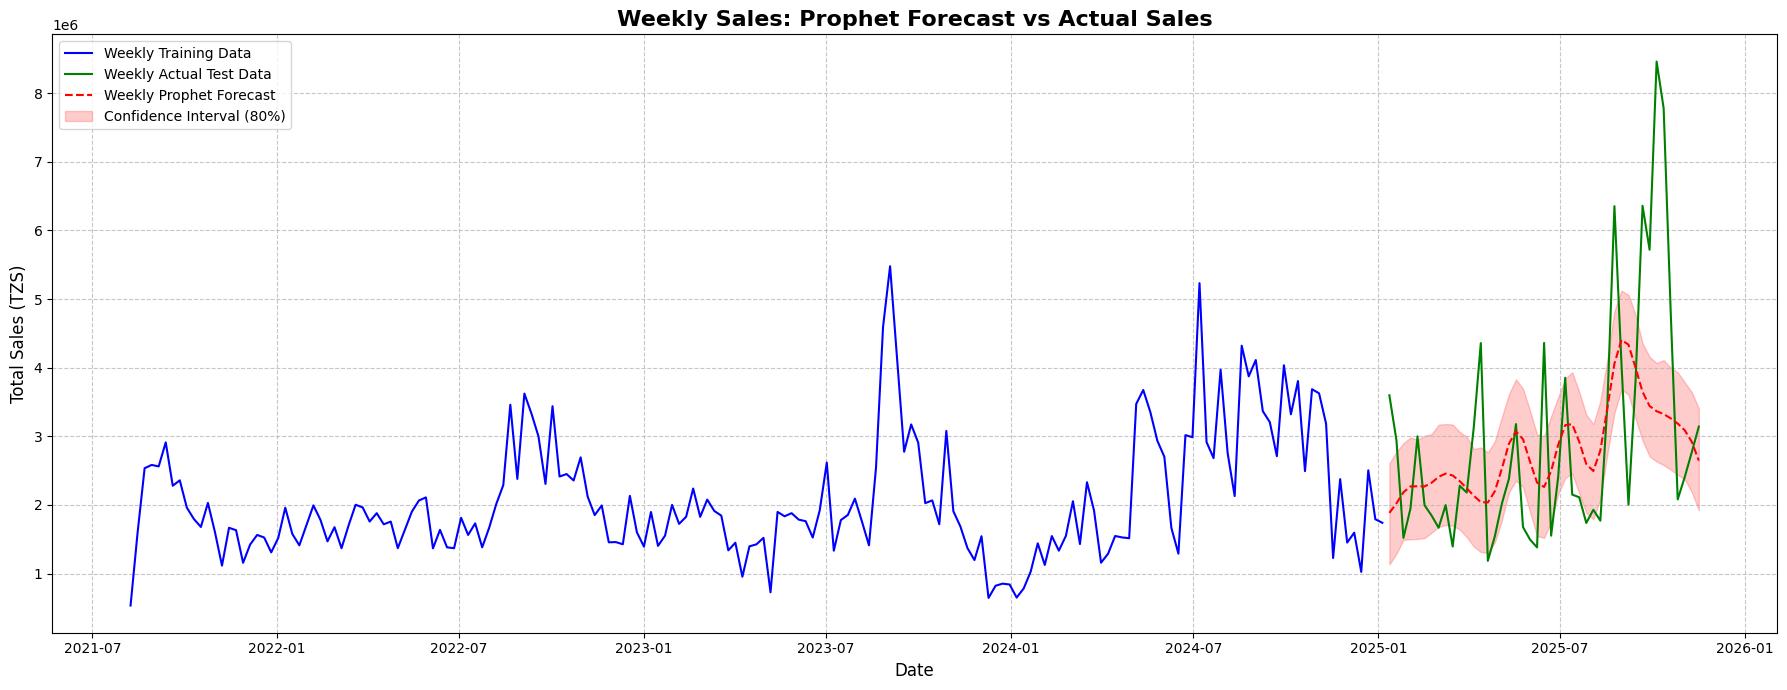


--- Monthly Prophet Forecast Results ---
Monthly Prophet Forecast MAE: 2,833,802.61
Monthly Prophet Forecast RMSE: 3,610,744.87

Monthly Test Data with Prophet Forecast (first 5 rows):


,Date,Sales,Prophet_Forecast,Prophet_Lower,Prophet_Upper
41,2025-01-31,1.069730e+07,1.258723e+07,1.101768e+07,1.412403e+07
42,2025-02-28,8.468596e+06,9.052070e+06,7.452941e+06,1.065886e+07
43,2025-03-31,8.613659e+06,9.527331e+06,8.050874e+06,1.102982e+07
44,2025-04-30,1.088368e+07,9.169244e+06,7.559469e+06,1.076118e+07
45,2025-05-31,9.573300e+06,1.351862e+07,1.198377e+07,1.515241e+07


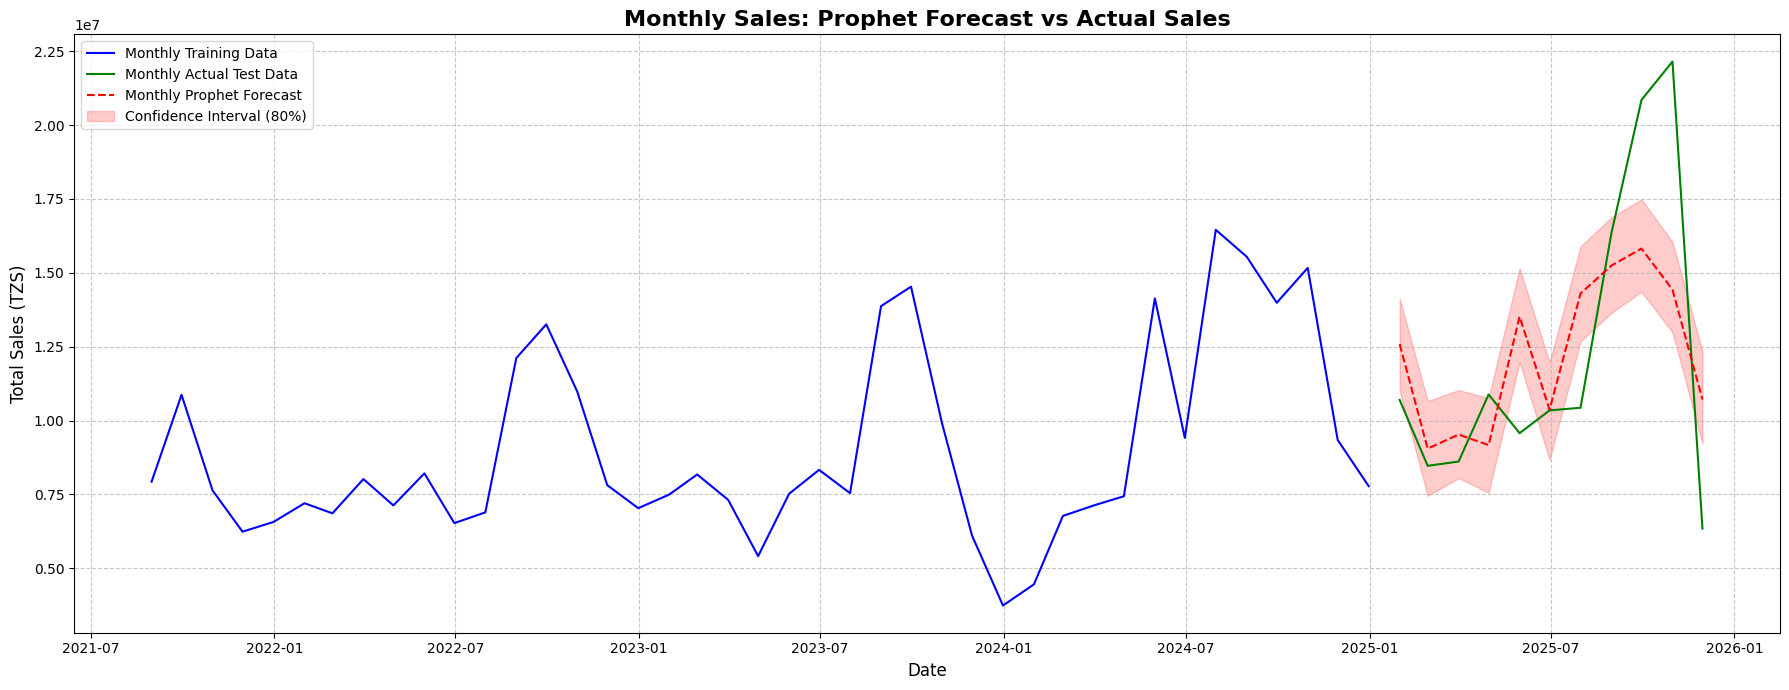


--- Weekly Prophet Components ---


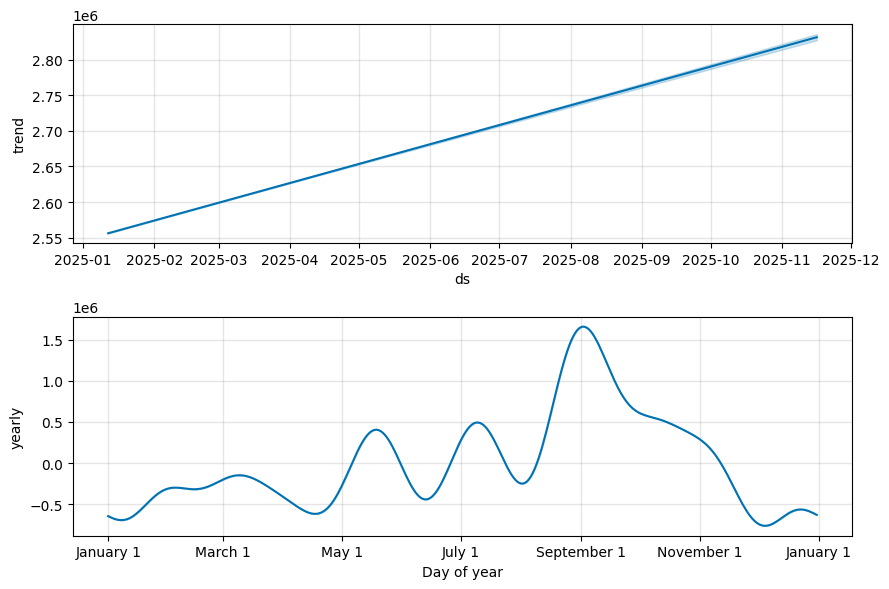


--- Monthly Prophet Components ---


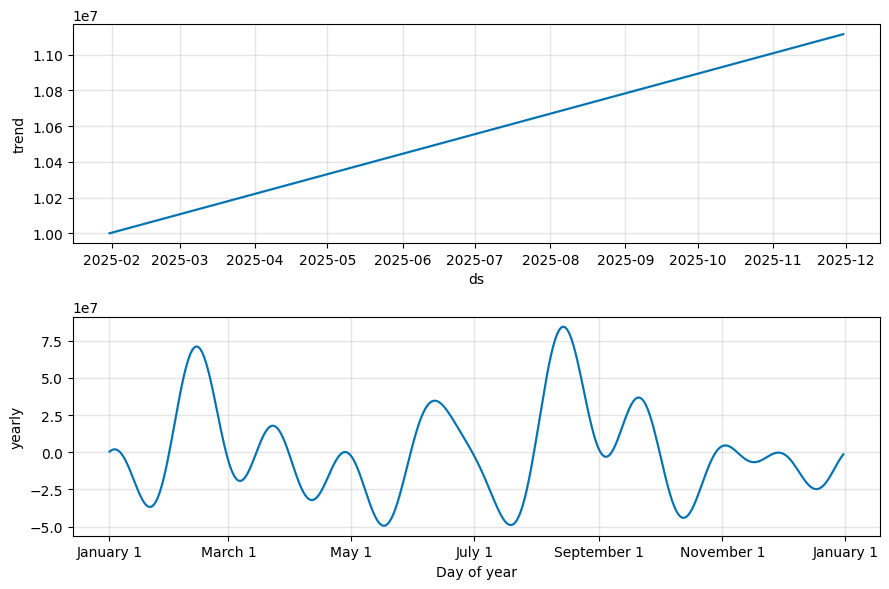

In [ ]:

# Prophet Forecast for Weekly Sales


# Preparing data in Prophet format (requires 'ds' and 'y' columns)
weekly_train_prophet = weekly_train.copy()
weekly_train_prophet = weekly_train_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})

weekly_test_prophet = weekly_test.copy()
weekly_test_prophet = weekly_test_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Initializing and fitting Prophet model
weekly_prophet_model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

weekly_prophet_model.fit(weekly_train_prophet)

# Generating forecast for the test period
weekly_future = weekly_test_prophet[['ds']].copy()
weekly_prophet_forecast = weekly_prophet_model.predict(weekly_future)

# Creating test forecast dataframe
weekly_test_forecast_prophet = weekly_test.copy()
weekly_test_forecast_prophet['Prophet_Forecast'] = weekly_prophet_forecast['yhat'].values
weekly_test_forecast_prophet['Prophet_Lower'] = weekly_prophet_forecast['yhat_lower'].values
weekly_test_forecast_prophet['Prophet_Upper'] = weekly_prophet_forecast['yhat_upper'].values

# Calculating evaluation metrics for weekly data
weekly_prophet_mae = mean_absolute_error(weekly_test_forecast_prophet['Sales'], weekly_test_forecast_prophet['Prophet_Forecast'])
weekly_prophet_rmse = np.sqrt(mean_squared_error(weekly_test_forecast_prophet['Sales'], weekly_test_forecast_prophet['Prophet_Forecast']))

print("\n--- Weekly Prophet Forecast Results ---")
print(f"Weekly Prophet Forecast MAE: {weekly_prophet_mae:,.2f}")
print(f"Weekly Prophet Forecast RMSE: {weekly_prophet_rmse:,.2f}")
print("\nWeekly Test Data with Prophet Forecast (first 5 rows):")
display(weekly_test_forecast_prophet[['Date', 'Sales', 'Prophet_Forecast', 'Prophet_Lower', 'Prophet_Upper']].head())

# Plotting Weekly Prophet Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_train, label='Weekly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=weekly_test_forecast_prophet, label='Weekly Actual Test Data', color='green')
sns.lineplot(x='Date', y='Prophet_Forecast', data=weekly_test_forecast_prophet, label='Weekly Prophet Forecast', color='red', linestyle='--')
plt.fill_between(weekly_test_forecast_prophet['Date'],
                 weekly_test_forecast_prophet['Prophet_Lower'],
                 weekly_test_forecast_prophet['Prophet_Upper'],
                 alpha=0.2, color='red', label='Confidence Interval (80%)')
plt.title('Weekly Sales: Prophet Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Prophet Forecast for Monthly Sales


# Preparing data in Prophet format
monthly_train_prophet = monthly_train.copy()
monthly_train_prophet = monthly_train_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})

monthly_test_prophet = monthly_test.copy()
monthly_test_prophet = monthly_test_prophet.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Initializing and fit Prophet model
monthly_prophet_model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.01
)

monthly_prophet_model.fit(monthly_train_prophet)

# Generating forecast for the test period
monthly_future = monthly_test_prophet[['ds']].copy()
monthly_prophet_forecast = monthly_prophet_model.predict(monthly_future)

# Creating test forecast dataframe
monthly_test_forecast_prophet = monthly_test.copy()
monthly_test_forecast_prophet['Prophet_Forecast'] = monthly_prophet_forecast['yhat'].values
monthly_test_forecast_prophet['Prophet_Lower'] = monthly_prophet_forecast['yhat_lower'].values
monthly_test_forecast_prophet['Prophet_Upper'] = monthly_prophet_forecast['yhat_upper'].values

# Calculating evaluation metrics for monthly data
monthly_prophet_mae = mean_absolute_error(monthly_test_forecast_prophet['Sales'], monthly_test_forecast_prophet['Prophet_Forecast'])
monthly_prophet_rmse = np.sqrt(mean_squared_error(monthly_test_forecast_prophet['Sales'], monthly_test_forecast_prophet['Prophet_Forecast']))

print("\n--- Monthly Prophet Forecast Results ---")
print(f"Monthly Prophet Forecast MAE: {monthly_prophet_mae:,.2f}")
print(f"Monthly Prophet Forecast RMSE: {monthly_prophet_rmse:,.2f}")
print("\nMonthly Test Data with Prophet Forecast (first 5 rows):")
display(monthly_test_forecast_prophet[['Date', 'Sales', 'Prophet_Forecast', 'Prophet_Lower', 'Prophet_Upper']].head())

# Plotting Monthly Prophet Forecast
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_train, label='Monthly Training Data', color='blue')
sns.lineplot(x='Date', y='Sales', data=monthly_test_forecast_prophet, label='Monthly Actual Test Data', color='green')
sns.lineplot(x='Date', y='Prophet_Forecast', data=monthly_test_forecast_prophet, label='Monthly Prophet Forecast', color='red', linestyle='--')
plt.fill_between(monthly_test_forecast_prophet['Date'],
                 monthly_test_forecast_prophet['Prophet_Lower'],
                 monthly_test_forecast_prophet['Prophet_Upper'],
                 alpha=0.2, color='red', label='Confidence Interval (80%)')
plt.title('Monthly Sales: Prophet Forecast vs Actual Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Weekly components
print("\n--- Weekly Prophet Components ---")
fig1 = weekly_prophet_model.plot_components(weekly_prophet_forecast)
plt.tight_layout()
plt.show()

# Monthly components
print("\n--- Monthly Prophet Components ---")
fig2 = monthly_prophet_model.plot_components(monthly_prophet_forecast)
plt.tight_layout()
plt.show()

# Tuning Prophet Hyperparameters



